In [1]:
import math
import numpy as np
import pandas as pd
import scipy.stats as st
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

def _parse_if_number(s):
    try: return int(s)
    except:
        try: return float(s)
        except: return True if s=="true" else False if s=="false" else s if s else None

df = pd.read_csv('General.csv', converters = {'value': _parse_if_number})

def _split_by_types(df, types):
    result = list()
    for t in types:
        mask = df['type'] == t
        result.append(df[mask])
        df = df[~mask]
    result.append(df)
    return result

itervars, runattrs, configs, attrs, df = _split_by_types(df, ["itervar", "runattr", "config", "attr"])

def _append_metadata_columns(df, meta, suffix):
    meta = pd.pivot_table(meta, index="run", columns="attrname", values="attrvalue", aggfunc="first")

    if not meta.empty:
        df = df.join(meta, on="run", rsuffix=suffix)
    return df

df = _append_metadata_columns(df, itervars, "_itervar")

del attrs, configs, itervars, runattrs
df = df[['value', 'lambda']]

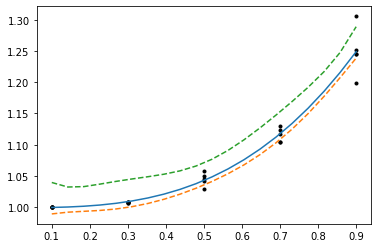

In [134]:
#Bootstrap CB
def func(x, a=0.3353, b=0.0060, c=0.0005, d=0.9992):
    return a*x**3 + b*x**2 + c*x + d 

def d_func(x, a=0.3353, b=0.0060, c=0.0005, d=0.9992):
    return [ x**3, x**2, x, 1 ] 

def bootstrap_cb(B = 100, n = 50, alpha = 0.95): 
    sigma = 0.2 #TODO variance of the data
    np.random.seed(42)
    C = []
    for _ in range(B):
        # Bootstrap n y samples
        x_n = np.random.choice(xs, size=n)
        y_n = [f + np.random.normal(0, sigma**2) for f in func(x_n)]
        # Perform ML estimation of the parameters
        popt, pcov = curve_fit(func, x_n, y_n) #TODO MLE
        # ?
        C_j = (popt-opt) @ np.linalg.inv(cov) @ (popt-opt) #TODO inv_cov
        C.append(C_j)
    C_L = np.percentile(C, 100*(1-alpha)) #TODO falsch, so wie jetzt
    C_U = np.percentile(C, 100*(alpha))
    h_lower = lambda x: np.sqrt( C_L * ( d_func(x, *opt) @ cov @ d_func(x, *opt) ) ) #TODO cov
    h_upper = lambda x: np.sqrt( C_U * ( d_func(x, *opt) @ cov @ d_func(x, *opt) ) )
    return h_lower, h_upper

x = np.linspace(0.1, 0.9, num=20)
xs = [float(i) for i in df['lambda'].unique()]
data = [df[ df['lambda'].values == i ].value.values for i in df['lambda'].unique()]
ys = [np.mean(df[ df['lambda'].values == i ].value.values) for i in df['lambda'].unique()]

opt, cov = curve_fit(func, xs, ys) #TODO MLE
h_lower, h_upper = bootstrap_cb()

plt.plot(xs, data, 'o', color='black', markersize='3')
# plt.plot(xs, ys, 'o', color='black', markersize='3')
plt.plot(x, [func(x_i, *opt) for x_i in x])
plt.plot(x, [func(x_i, *opt) - h_lower(x_i) for x_i in x], linestyle='dashed')
plt.plot(x, [func(x_i, *opt) + h_upper(x_i) for x_i in x], linestyle='dashed')

In [ ]:
#Bootstrap CI
def bootstrap_ci(values): 
    alpha = 0.95
    n = 100
    B = 10000
    np.random.seed(42)
    sample_mean = []
    for _ in range(B): 
        sample_n = np.random.choice(values, size=n)
        sample_mean.append(sample_n.mean())
    mean = np.mean(sample_mean)
    lower_ci = np.percentile(sample_mean, 100*(1-alpha))
    upper_ci = np.percentile(sample_mean, 100*(alpha))
    return { 'mean': mean, 'lower_ci': lower_ci, 'upper_ci': upper_ci }

df = pd.pivot_table(df, values="value", index="lambda", aggfunc=[bootstrap_ci], dropna=False)
xs = df["bootstrap_ci"].index.values
ys = [ x['mean'] for x in df["bootstrap_ci"].value.values]
confint_U = [ x['upper_ci'] for x in df["bootstrap_ci"].value.values]
confint_L = [ x['lower_ci'] for x in df["bootstrap_ci"].value.values]

plt.plot(xs, ys)
plt.plot(xs, confint_L, confint_U)

In [ ]:
#normal CI
plt.figure()

def mean(values): 
    return np.mean(values)

def confint(values): 
    return st.norm.interval(0.95, loc=0, scale=st.sem(values))[1] if len(values) > 1 else math.nan

normal_df = pd.pivot_table(df, values="value", index="lambda", aggfunc=[mean, confint], dropna=False)
xs = normal_df["mean"].index.values
ys = normal_df["mean"]["value"].values
confint_U = normal_df["confint"]["value"].values
confint_L = normal_df["confint"]["value"].values

plt.plot(xs, ys)
plt.plot(xs,ys-confint_L, ys+confint_U, linestyle='dashed')